In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [1]:
import torch
import kagglehub
import pandas as pd
from data_loader import CustomDataLoader
from train import TrainingLoop
from eval import Evaluate
import torch.nn.functional as F

# added for plots
import matplotlib.pyplot as plt

# added for to save the loss values for reuse if a plot needs to be remade
import os
import json
torch.manual_seed(1337)

## Download Dataset

In [2]:
# Download latest version of test dataset
test_path = kagglehub.dataset_download("mdismielhossenabir/sentiment-analysis")

print("Path to dataset files:", test_path)

Path to dataset files: C:\Users\pesta\.cache\kagglehub\datasets\mdismielhossenabir\sentiment-analysis\versions\1


In [3]:
# Download the dataset to the specified path
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pesta\.cache\kagglehub\datasets\jp797498e\twitter-entity-sentiment-analysis\versions\2


## Read data into CSV files

In [4]:
train_df = pd.read_csv(f"{path}/twitter_training.csv", header = None)
val_df = pd.read_csv(f"{path}/twitter_validation.csv", header = None)

In [5]:
test_df = pd.read_csv(f"{test_path}/sentiment_analysis.csv")

In [6]:
# Apply camel casing
test_df['sentiment'] = test_df['sentiment'].str.capitalize()

In [7]:
test_df.rename(columns={'sentiment': 2}, inplace=True)
test_df.rename(columns={'text': 3}, inplace=True)

In [8]:
x = train_df.shape[0] + val_df.shape[0]
print(f"Total number of samples: {x}")
print(f"Number of samples in training set: {train_df.shape[0]}")
print(f"Number of samples in validation set: {val_df.shape[0]}")

Total number of samples: 75682
Number of samples in training set: 74682
Number of samples in validation set: 1000


## Load data in CustomDataLoader

In [9]:
text_col = 3    # Column index for input text
label_col = 2   # Column index for labels
batch_size = 64 * 2 # Batch size for training and validation

# Initialize CustomDataLoader
custom_loader = CustomDataLoader(train_df, val_df, test_df, text_col, label_col, batch_size)

# Get train and validation loaders
train_loader = custom_loader.get_train_loader(shuffle=True)
val_loader = custom_loader.get_val_loader(shuffle=True)
test_loader = custom_loader.get_test_loader(shuffle=False)

## Define Model Params

In [10]:
model_version = "18"

In [11]:
model_params = {
    "vocab_size": train_loader.dataset.vocab_size,
    "num_embeddings": int(384*1.5),
    "block_size": train_loader.dataset.block_size,
    "num_heads": int(6 * 1.5),
    "num_layers": 6,
    "output_classes": len(train_loader.dataset.labels_lookup_dict),
    "dropout": 0.2/2,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}


## Define Training Params

In [12]:
train_params = {
    "num_epochs": 5000,
    "eval_interval": 500,
    "eval_iters": 500,
    "learning_rate": 3e-4/2
}

## Code to parse old saved outputs and convert them into train and val dictionaries usable by the JSON save function (for models created before loss data was automatically stored in the loss JSON file)
The loss data for these models were originally stored in a text file

In [11]:
# Lines of interest are of the following format:
# 2024-12-02 23:34:37.293 | INFO     | train:train:135 - For epoch 0: Train loss-> 1.3974379754066468 | Val loss-> 1.395492012500763

# Paste raw output here (Contains special characters, some of which are tacked on to the end of the validation 
raw_text = """
2024-12-03 00:12:49.036 | INFO     | train:train:135 - For epoch 0: Train loss-> 1.401136145591736 | Val loss-> 1.3954114282131196
2024-12-03 00:12:49.147 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_0.pth
2024-12-03 00:12:49.257 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-03 00:13:11.692 | INFO     | train:train:135 - For epoch 50: Train loss-> 1.3476397531032562 | Val loss-> 1.3485286581516265
2024-12-03 00:13:11.809 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_50.pth
2024-12-03 00:13:11.922 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-03 00:13:26.518 | INFO     | train:train:135 - For epoch 100: Train loss-> 1.3286450238227845 | Val loss-> 1.3242574632167816
2024-12-03 00:13:26.636 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_100.pth
2024-12-03 00:13:26.761 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-03 00:13:36.826 | INFO     | train:train:135 - For epoch 150: Train loss-> 1.2999500081539155 | Val loss-> 1.2846487443447112
2024-12-03 00:13:36.947 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_150.pth
2024-12-03 00:13:37.059 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-03 00:13:47.151 | INFO     | train:train:135 - For epoch 200: Train loss-> 1.2861177718639374 | Val loss-> 1.2801540467739105
2024-12-03 00:13:47.254 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_200.pth
2024-12-03 00:13:47.349 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-03 00:13:57.867 | INFO     | train:train:135 - For epoch 250: Train loss-> 1.2676267681121827 | Val loss-> 1.2557220368385316
2024-12-03 00:13:57.983 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_250.pth
2024-12-03 00:13:58.081 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-03 00:14:08.503 | INFO     | train:train:135 - For epoch 300: Train loss-> 1.2783513350486755 | Val loss-> 1.2828768928050995
2024-12-03 00:14:08.609 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_300.pth
2024-12-03 00:14:19.120 | INFO     | train:train:135 - For epoch 350: Train loss-> 1.2628617616891862 | Val loss-> 1.2337264609336853
2024-12-03 00:14:19.229 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_350.pth
2024-12-03 00:14:19.332 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
2024-12-03 00:14:29.816 | INFO     | train:train:135 - For epoch 400: Train loss-> 1.2400790109634399 | Val loss-> 1.2346852452754975
2024-12-03 00:14:29.922 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_400.pth
2024-12-03 00:14:40.149 | INFO     | train:train:135 - For epoch 450: Train loss-> 1.2302005734443664 | Val loss-> 1.2137968860864639
2024-12-03 00:14:40.256 | INFO     | train:save_checkpoint:72 - Checkpoint saved: ./models/model_test/checkpoint_epoch_450.pth
2024-12-03 00:14:40.355 | INFO     | train:save_checkpoint:77 - Best model saved: ./models/model_test/best_model.pth
"""
# train_dict = {}
# val_dict = {}
# line_split = raw_text.split("\n")
# for line in line_split:
#     word_split = line.split(" ")
#     for word in range(len(word_split)):
#         if word_split[word] == "epoch":
#             # convert to float to keep consistent with the dictionary key vals coming from the train function return
#             # float string has an ':' appendeded to the end, so we need to remove it
#             epoch = float(word_split[word+1][:-1])
#         elif word_split[word] == "loss->":
#             if word_split[word-1] == "Train":
#                 train_dict[epoch] = float(word_split[word+1])
#             elif word_split[word-1] == "Val":
#                 val_dict[epoch]= float(word_split[word+1])

## Training Loop

In [12]:
save_models_path = "./models/model_"+ model_version
#TrainingLoop(model_params, train_params).train(train_loader, val_loader, save_models_path, resume_path="./models_v1/best_model.pth")
train_dict, val_dict = TrainingLoop(model_params, train_params).train(train_loader, val_loader, save_models_path)

2024-12-07 00:26:17.312 | DEBUG    | train:train:110 - Number of model parameters: 81800644
2024-12-07 00:28:29.918 | INFO     | train:train:137 - For epoch 0: Train loss-> 5.730189050674438 | Val loss-> 5.893553816795349
2024-12-07 00:28:30.874 | INFO     | train:save_checkpoint:73 - Checkpoint saved: ./models/model_16/checkpoint_epoch_0.pth
2024-12-07 00:28:31.848 | INFO     | train:save_checkpoint:78 - Best model saved: ./models/model_16/best_model.pth
2024-12-07 00:34:13.751 | INFO     | train:train:137 - For epoch 500: Train loss-> 0.914760602235794 | Val loss-> 0.8516015535593033
2024-12-07 00:34:14.711 | INFO     | train:save_checkpoint:73 - Checkpoint saved: ./models/model_16/checkpoint_epoch_500.pth
2024-12-07 00:34:15.656 | INFO     | train:save_checkpoint:78 - Best model saved: ./models/model_16/best_model.pth
2024-12-07 00:39:57.048 | INFO     | train:train:137 - For epoch 1000: Train loss-> 0.5402453773617745 | Val loss-> 0.4856861502528191
2024-12-07 00:39:57.968 | INFO  

In [13]:
train_dict

{0: 5.730189050674438,
 500: 0.914760602235794,
 1000: 0.5402453773617745,
 1500: 0.3042392526566982,
 2000: 0.1677331696897745,
 2500: 0.11245388191193342,
 3000: 0.10160131844505668,
 3500: 0.0861424178685993,
 4000: 0.07445414428412914,
 4500: 0.07463255780749023}

In [14]:
model_version

'16'

Create or update a JSON file containing a list of all loss plots, saved as dictionaries

In [15]:
# Combine train_dict and val_dict into a single dictionary
current_model = "model_" + model_version
combined_dict = {
    # 'model_version': current_model,
    'train_dict': train_dict,
    'val_dict': val_dict
}

# If the JSON file already exists, add or update it
if os.path.exists('model_loss_dicts.json'):
    with open('model_loss_dicts.json', 'r') as json_file:
        all_lists = json.load(json_file)
        all_lists[current_model] = combined_dict
        # file path will be in the same directory as the notebook
        # Updating and adding to the JSON file is the same
        with open('model_loss_dicts.json', 'w') as json_file:
            json.dump(all_lists, json_file, indent=4)
            
# # If the JSON file does not exists, it is the first run; create a new JSON file with the combined dictionary
else:
# # Save the combined dictionary to a JSON file
    all_lists = {}
    all_lists[current_model] = combined_dict
    with open('model_loss_dicts.json', 'w') as json_file:
        json.dump(all_lists, json_file, indent=4)

Compare current model with base model

In [26]:
# For manual designation
target_model = "model_16"

# For current model
#target_model = current_model

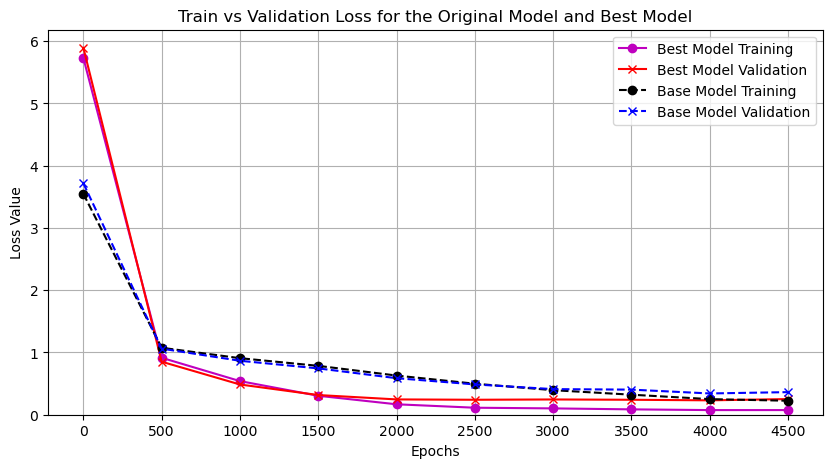

In [14]:


# Whether to compare the target model with the original model
comparison = True

# Load the loss values from the JSON file
with open('model_loss_dicts.json', 'r') as json_file:
    # all_list is a dict of model dicts, 
    # each model dict has a train_dict and val_dict
    all_lists = json.load(json_file)

# Get the train dictionary
train_x = all_lists[target_model]['train_dict'].keys()
train_y = all_lists[target_model]['train_dict'].values()


# Get the validation dictionary
val_x = all_lists[target_model]['val_dict'].keys()
val_y = all_lists[target_model]['val_dict'].values()

if comparison:
    # Get the original model version for comparison
    train_x0 = all_lists["model_0"]['train_dict'].keys()
    train_y0 = all_lists["model_0"]['train_dict'].values()
    val_x0 = all_lists["model_0"]['val_dict'].keys()
    val_y0 = all_lists["model_0"]['val_dict'].values()
    plt.figure(figsize=(10, 5))
    plt.plot(train_x, train_y, marker='o', linestyle='-', color='m', label= 'Best Model Training') #'Model ' + target_model.replace("model_", "") + ' Training')
    plt.plot(val_x, val_y, marker='x', linestyle='-', color='r', label = 'Best Model Validation') #'Model ' + target_model.replace("model_", "") + ' Validation')
    plt.plot(train_x0, train_y0, marker='o', linestyle='--', color='k', label= 'Base Model Training')
    plt.plot(val_x0, val_y0, marker='x', linestyle='--', color='b', label = 'Base Model Validation')

    # Add titles and labels
    #title = 'Train vs Validation Loss for the Original Model and  Model ' + target_model.replace("model_", "")
    title = 'Train vs Validation Loss for the Original Model and Best Model'
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.ylim(bottom=0)

    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

else:
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_x, train_y, marker='o', linestyle='-', color='b', label='Training')
    plt.plot(val_x, val_y, marker='x', linestyle='-', color='r', label='Validation')

    # Add titles and labels
    title = 'Train vs Validation Loss for Model ' + target_model.replace("model_", "")
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.ylim(bottom=0)

    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

Comparison of the best model, as well as 2 changes to the transformer architecture: Post-LN configuration, and removal of LN before output

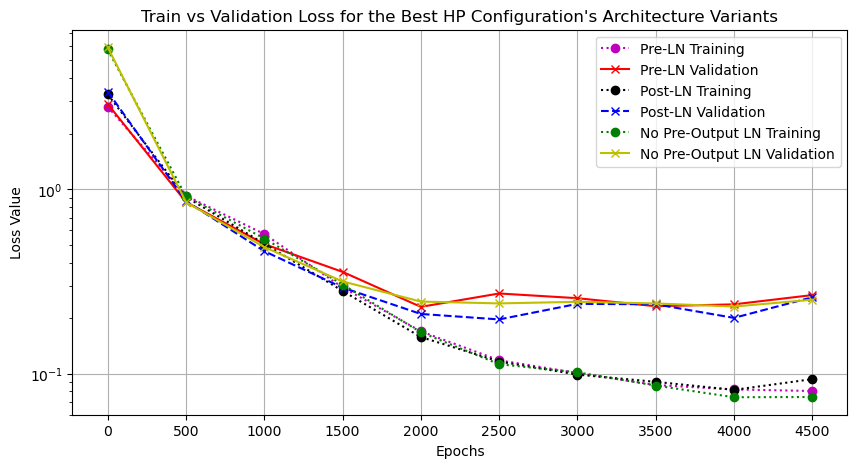

In [ ]:
# Original best model
train_x0 = all_lists["model_14"]['train_dict'].keys()
train_y0 = all_lists["model_14"]['train_dict'].values()
val_x0 = all_lists["model_14"]['val_dict'].keys()
val_y0 = all_lists["model_14"]['val_dict'].values()

# Best model Post-LN Variant
train_x1 = all_lists["model_15"]['train_dict'].keys()
train_y1 = all_lists["model_15"]['train_dict'].values()
val_x1 = all_lists["model_15"]['val_dict'].keys()
val_y1 = all_lists["model_15"]['val_dict'].values()

# Best model no pre-output layer LN
train_x2 = all_lists["model_16"]['train_dict'].keys()
train_y2 = all_lists["model_16"]['train_dict'].values()
val_x2 = all_lists["model_16"]['val_dict'].keys()
val_y2 = all_lists["model_16"]['val_dict'].values()


plt.figure(figsize=(10, 5))
plt.plot(train_x0, train_y0, marker='o', linestyle=':', color='m', label= 'Pre-LN Training')
plt.plot(val_x0, val_y0, marker='x', linestyle='-', color='r', label = 'Pre-LN Validation') 
plt.plot(train_x1, train_y1, marker='o', linestyle=':', color='k', label= 'Post-LN Training')
plt.plot(val_x1, val_y1, marker='x', linestyle='-', color='b', label = 'Post-LN Validation')
plt.plot(train_x2, train_y2, marker='o', linestyle=':', color='g', label= 'No Pre-Output LN Training')
plt.plot(val_x2, val_y2, marker='x', linestyle='-', color='y', label = 'No Pre-Output LN Validation')

# Add titles and labels
#title = 'Train vs Validation Loss for the Original Model and  Model ' + target_model.replace("model_", "")
title = "Train vs Validation Loss for the Best HP Configuration's Architecture Variants"
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
#plt.ylim(bottom=0)

# Set y-axis to log scale so its easier to see the differences in lines
plt.yscale('log')

plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Evaluate Best model- load it from checkpoint

In [27]:
val_loader = custom_loader.get_val_loader(shuffle=False)
# Manually load the best model
best_model_path = "./models/" + target_model + "/best_model.pth"

# Load the best iteration of the current model
# best_model_path = "./models/model_test/best_model.pth"


label_mapping = train_loader.dataset.reverse_labels_lookup_dict
# NOTE: Requires model_params to match intended model
report = Evaluate(model_params, best_model_path).evaluate(val_loader, label_mapping)

c:\Users\pesta\Documents\GithubRepos\CSC871-Term-Project\GPTDecoder\eval.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.best_model_path, m

In [28]:
print(report)

              precision    recall  f1-score   support

  Irrelevant     0.9357    0.9302    0.9329       172
    Negative     0.9624    0.9624    0.9624       266
     Neutral     0.9477    0.9544    0.9510       285
    Positive     0.9420    0.9386    0.9403       277

    accuracy                         0.9480      1000
   macro avg     0.9470    0.9464    0.9467      1000
weighted avg     0.9480    0.9480    0.9480      1000



In [21]:
# Evaluate using the secondary generalized test set
report = Evaluate(model_params, best_model_path).evaluate(test_loader, label_mapping)

c:\Users\pesta\Documents\GithubRepos\CSC871-Term-Project\GPTDecoder\eval.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.best_model_path, m

In [22]:
print(report)

              precision    recall  f1-score   support

  Irrelevant     0.0000    0.0000    0.0000         0
    Negative     0.4571    0.2388    0.3137       134
     Neutral     0.4124    0.2010    0.2703       199
    Positive     0.4356    0.5904    0.5013       166

    accuracy                         0.3407       499
   macro avg     0.3263    0.2575    0.2713       499
weighted avg     0.4321    0.3407    0.3588       499



## Infer on Raw text

In [19]:
model = Evaluate(model_params, best_model_path).model

c:\Users\pesta\Documents\GithubRepos\CSC871-Term-Project\GPTDecoder\eval.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.best_model_path, m

In [20]:
def infer_on_raw_text(raw_text: str) -> str:

  encoded_inp = torch.tensor(train_loader.dataset.encode_text(raw_text), dtype=torch.long, device=model_params.get('device')).unsqueeze(0)
  logits = model(encoded_inp)
  probs = F.softmax(logits[0], dim=-1)
  # Find the index of the largest element
  max_index = torch.argmax(probs, dim=1)

  label = label_mapping[max_index.item()]
  # print("probs: ", probs)
  return label

In [21]:
text = "I'm so happy"
infer_on_raw_text(text)

'Positive'

In [22]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base") # hardcoding this for now
vocab_size = tokenizer.n_vocab  # Vocabulary size from the tokenizer
print("Vocabulary size:", vocab_size)

Vocabulary size: 100277
